# Open Telemetry

Now that we're pushing our system into production, how can we ensure we're working with a well oiled system? 

In [1]:
%load_ext autoreload
%autoreload 2

## Automatic Labelling

In [14]:
from lib.data import get_labels
from lib.models import QueryItem
import pandas as pd
import json
from lib.classify import tag_queries
import random


# Setup Test Files
queries = get_labels("../data/queries_single_label.jsonl")[:20]
queries = [
    QueryItem(
        **{"query": item["query"], "selected_chunk_ids": [item["selected_chunk_ids"]]}
    )
    for item in queries
]

def random_topic_model(query:str):
    return random.choice([1,2,3])

tagged_queries = await tag_queries(queries,20,random_topic_model)

df = pd.DataFrame([json.loads(item.model_dump_json()) for item in tagged_queries])

topic_model_mapping = {
    1: "Calendar Lookup",
    2: "Email",
    3: "Data Analysis"
}

# Apply the mapping to the 'topic_model' column
df['topic_model'] = df['topic_model'].map(topic_model_mapping)
df['capabilities'] = df['capabilities'].astype(str)
df['capabilities'] = df['capabilities'].str.strip('[]').str.split(', ')
df = df.explode('capabilities')
df.groupby(["topic_model","capabilities"]).size()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.14it/s]


topic_model      capabilities                   
Calendar Lookup  'Flight Information Retrieval'     2
                 'Historical Price Information'     5
                 'Latest News'                      3
                 'Product Information Retrieval'    4
                 'Restaurant Recomendations'        2
                 'Retrieve Calendar'                2
                 'Search Email'                     2
Data Analysis    'Historical Price Information'     1
                 'Latest News'                      2
                 'Product Information Retrieval'    4
                 'Search Email'                     2
Email            'Historical Price Information'     3
                 'Product Information Retrieval'    4
                 'Search Email'                     2
dtype: int64

## Performance Metrics

For instance, if we're deploying certain improvements to our retrieval pipeline, we want to measure the performance of that retrieval pipeline

In [35]:
from lib.models import QueryItem
from lib.query import fts_search
import lancedb
from lib.eval import score_retrieval, calculate_reciprocal_rank, calculate_recall
from lib.data import get_labels
from lib.db import get_table
import pandas as pd

# Setup Test Files
db = lancedb.connect("../lance")
queries = get_labels("../data/queries_single_label.jsonl")[:5]
queries = [
    QueryItem(
        **{"query": item["query"], "selected_chunk_ids": [item["selected_chunk_ids"]]}
    )
    for item in queries
]
table = get_table(db, "ms_marco")
query_embeddings = generate_embeddings(queries, 20)


Generating Embeddings for 5 queries: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]


In [36]:
data=[]
sizes = [3,5,10]

reranker = CohereReranker(model_name="rerank-multilingual-v3.0")
for query, query_embed in tqdm(zip(queries,query_embeddings)):
    items = table.search(query.query, query_type="hybrid").limit(25).to_list()
    reranked_items = table.search(query.query, query_type="hybrid").limit(25).rerank(reranker=reranker).to_list()
    
    evaluation_k = max(sizes)
    item_vectors = [item['vector'] for item in items][:evaluation_k]
    reranked_item_vectors = [item['vector'] for item in reranked_items][:evaluation_k]

    result = {}
    for size in sizes:
        item_cos_similarities = cosine_similarity(item_vectors[:size], [query_embed]).flatten()
        reranked_item_cos_similarities = cosine_similarity(reranked_item_vectors[:size], [query_embed]).flatten()
        result[f'orig@{size}']=np.mean(item_cos_similarities)
        result[f'rerank@{size}']=np.mean(reranked_item_cos_similarities)

    data.append(result)


0it [00:00, ?it/s]/Users/ivanleo/Documents/rag-ws/venv/lib/python3.12/site-packages/lancedb/rerankers/cohere.py:89: FutureWarning: promote has been superseded by promote_options='default'.
  combined_results = self.merge_results(vector_results, fts_results)

1it [00:02,  2.56s/it]/Users/ivanleo/Documents/rag-ws/venv/lib/python3.12/site-packages/lancedb/rerankers/cohere.py:89: FutureWarning: promote has been superseded by promote_options='default'.
  combined_results = self.merge_results(vector_results, fts_results)

2it [00:04,  2.07s/it]/Users/ivanleo/Documents/rag-ws/venv/lib/python3.12/site-packages/lancedb/rerankers/cohere.py:89: FutureWarning: promote has been superseded by promote_options='default'.
  combined_results = self.merge_results(vector_results, fts_results)

3it [00:06,  1.92s/it]/Users/ivanleo/Documents/rag-ws/venv/lib/python3.12/site-packages/lancedb/rerankers/cohere.py:89: FutureWarning: promote has been superseded by promote_options='default'.
  combined_results = 

In [37]:
df = pd.DataFrame(data)
df

,orig@3,rerank@3,orig@5,rerank@5,orig@10,rerank@10
0,0.678479,0.671113,0.652739,0.610257,0.582797,0.546982
1,0.694058,0.694058,0.651044,0.642253,0.545194,0.529477
2,0.582549,0.570964,0.576979,0.553540,0.522538,0.523259
3,0.743460,0.743460,0.719389,0.734642,0.694050,0.691304
4,0.357981,0.409151,0.365405,0.408302,0.340605,0.380518


# Logfire

In [3]:
import logfire

!logfire auth 

You are already logged in. (Your credentials are stored in 
/Users/ivanleo/.logfire/default.toml)


In [6]:
import logfire
from datetime import date

logfire.configure()

Logfire project URL: ]8;id=919516;https://logfire.pydantic.dev/ivanleomk/logfire-demo\https://logfire.pydantic.dev/ivanleomk/logfire-demo]8;;\

In [8]:
logfire.info('Hello, {name}!', name='world')  

with logfire.span('Asking the user their {question}', question='age'):  
    user_input = input('How old are you [YYYY-mm-dd]? ')
    dob = date.fromisoformat(user_input)  
    logfire.debug('{dob=} {age=!r}', dob=dob, age=date.today() - dob)

08:27:41.402 Hello, world!
08:27:41.403 Asking the user their age


How old are you [YYYY-mm-dd]?  1997-06-04


## Exceptions

What happens when we see errors?

In [9]:

logfire.info('Hello, {name}!', name='world')  

with logfire.span('Asking the user their {question}', question='age'):  
    user_input = input('How old are you [YYYY-mm-dd]? ')
    dob = date.fromisoformat(user_input)  
    logfire.debug('{dob=} {age=!r}', dob=dob, age=date.today() - dob)

08:29:40.943 Hello, world!
08:29:40.946 Asking the user their age


How old are you [YYYY-mm-dd]?  22


ValueError: Invalid isoformat string: '22'

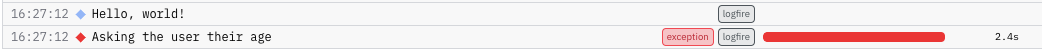

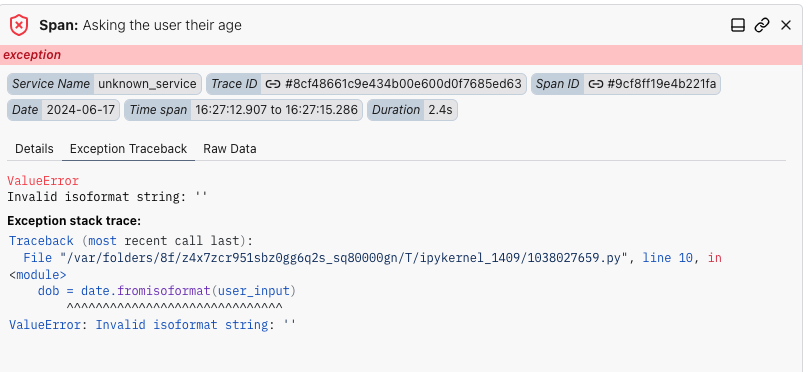

## Pydantic Validation

Pydantic is useful for us in production to prevent untyped objects from flying around and wrecking havoc. 

In [10]:
from datetime import date
import logfire
from pydantic import BaseModel

logfire.configure()

class User(BaseModel):
    name: str
    country_code: str
    dob: date

user = User(name='Anne', country_code='USA', dob='2000-01-01')
logfire.info('user processed: {user!r}', user=user) 

Logfire project URL: ]8;id=296794;https://logfire.pydantic.dev/ivanleomk/logfire-demo\https://logfire.pydantic.dev/ivanleomk/logfire-demo]8;;\

08:31:19.052 user processed: User(name='Anne', country_code='USA', dob=datetime.date(2000, 1, 1))


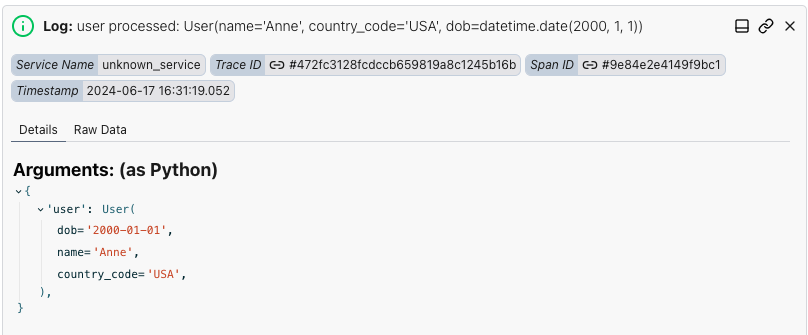

But what happens when we have invalid validation?

In [11]:
class User(BaseModel):
    name: str
    country_code: str
    dob: date

user = User(name='Anne', country_code='USA', dob='12344')

ValidationError: 1 validation error for User
dob
  Datetimes provided to dates should have zero time - e.g. be exact dates [type=date_from_datetime_inexact, input_value='12344', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/date_from_datetime_inexact

Turns out in order to log these validations, we need to configure the integration with Pydantic

In [12]:
logfire.configure(pydantic_plugin=logfire.PydanticPlugin(record='all'))  

class User(BaseModel):
    name: str
    country_code: str
    dob: date

user = User(name='Anne', country_code='USA', dob='12344')

Logfire project URL: ]8;id=217573;https://logfire.pydantic.dev/ivanleomk/logfire-demo\https://logfire.pydantic.dev/ivanleomk/logfire-demo]8;;\

08:42:31.401 Pydantic User validate_python


ValidationError: 1 validation error for User
dob
  Datetimes provided to dates should have zero time - e.g. be exact dates [type=date_from_datetime_inexact, input_value='12344', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/date_from_datetime_inexact

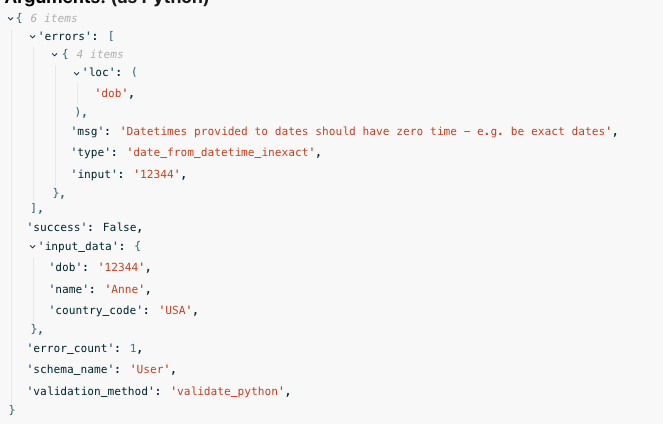

## I Don't have an integration

Just use manual logging

In [13]:
import time

import logfire

logfire.configure()

with logfire.span('This is a span'):
    time.sleep(1)
    logfire.info('This is an info log')
    time.sleep(2)

Logfire project URL: ]8;id=912725;https://logfire.pydantic.dev/ivanleomk/logfire-demo\https://logfire.pydantic.dev/ivanleomk/logfire-demo]8;;\

08:52:46.824 This is a span
08:52:47.830   This is an info log


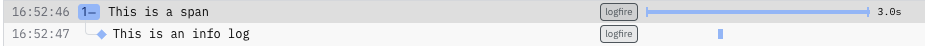

# Topic Modelling in Production

Why do we care about Open Telemetry

In [5]:
import random

def topic_model(query):
    return random.choice([1,2,3])

topic_model("This is a frog")

3

In [6]:
# Capability
from pydantic import BaseModel,Field
from typing import Literal

class Capability(BaseModel):
    capabilities: list[Literal['Web Search','Search Email','Retrieve Calendar']] = Field(...,description="This \
    is a list of capabilities that must be provided in order to execute/respond to the user's query")
    missing_capabilities: list[str] = Field(...,description="These are capabilities that are missing from the provided list \
    that you think should be provided")

In [7]:
import instructor
from openai import OpenAI

client = instructor.from_openai(OpenAI())

resp = client.chat.completions.create(
    model = "gpt-4o",
    response_model = Capability,
    messages = [
        {
            "role":"system",
            "content": "You are an advanced tagging system that excels at extracting what capabilites from the provided list \
            need to be used in order to answer a user's query."
        },
        {
            "role":"user",
            "content": "The query is 'Can you schedule a meeting with Daniel later this week?'"
        }
    ]
)
resp

Capability(capabilities=['Retrieve Calendar'], missing_capabilities=['Calendar Scheduling'])

In [18]:
class Capability(BaseModel):
    """
    This is a model representing an evaluation of the required capabilities to execute a task.

    A capability here is a brief 2-3 word phrase that describes a tool or function that is needed to fulfil a user request
    """
    capabilities: list[Literal['Web Search','Search Email','Retrieve Calendar']] = Field(...,description="This \
    is a list of capabilities that must be provided in order to execute/respond to the user's query")
    missing_capabilities: list[str] = Field(...,description="These are capabilities that are missing from the provided list \
    that you think should be provided")

class QueryTagger(BaseModel):
    capabilities: list[str]
    topic_model: int

def tag_query(query):
    resp = client.chat.completions.create(
    model = "gpt-3.5-turbo",
    response_model = Capability,
    messages = [
            {
                "role":"system",
                "content": "You are an advanced tagging system that excels at extracting what capabilites from the provided list \
                need to be used in order to answer a user's query."
            },
            {
                "role":"user",
                "content": f"The query is '{query}'"
            }
        ]
    )
    return QueryTagger(**{
        "capabilities": resp.capabilities + resp.missing_capabilities,
        "topic_model": topic_model(query)
    })

# tag_query("Can you schedule a chat with Daniel in the Tanjong Pagar room later in the week?")

What can we do with this? Well, it's extremely useful when we can segregate by topic and capabilities to see what to prioritise in our roadmap

In [22]:
from lib.data import get_labels

test_data = get_labels("../data/queries_single_label.jsonl")

In [23]:
len(test_data)

1066

In [9]:
tagged_queries = [
   tag_query(item['query']) for item in test_data
]
tagged_queries

[QueryTagger(capabilities=['Web Search'], topic_model=1),
 QueryTagger(capabilities=['Web Search'], topic_model=3),
 QueryTagger(capabilities=['Web Search'], topic_model=2),
 QueryTagger(capabilities=['Web Search'], topic_model=3),
 QueryTagger(capabilities=['Web Search'], topic_model=3),
 QueryTagger(capabilities=['Web Search'], topic_model=2),
 QueryTagger(capabilities=['Web Search'], topic_model=1),
 QueryTagger(capabilities=['Web Search'], topic_model=1),
 QueryTagger(capabilities=['Web Search'], topic_model=3),
 QueryTagger(capabilities=['Biology Knowledge'], topic_model=1)]

In [54]:
from openai import AsyncOpenAI
import instructor
from tqdm.asyncio import tqdm_asyncio as asyncio
from tenacity import retry, stop_after_attempt, wait_random_exponential
from asyncio import Semaphore

client = instructor.from_openai(AsyncOpenAI())
sem = Semaphore(20)



@retry(
        wait=wait_random_exponential(multiplier=1, min=10, max=90),
        stop=stop_after_attempt(3),
    )
async def tag_query(query):
    async with sem:
        resp = await client.chat.completions.create(
        model = "gpt-3.5-turbo",
        response_model = Capability,
        messages = [
                {
                    "role":"system",
                    "content": "You are an advanced tagging system that excels at extracting what capabilites from the provided list \
                    need to be used in order to answer a user's query."
                },
                {
                    "role":"user",
                    "content": f"The query is '{query}'"
                }
            ],
            max_retries=3
        )
        return QueryTagger(**{
            "capabilities": resp.capabilities,
            "topic_model": topic_model(query),
            "query": query
        })

async def process_queries(data:list[str]):
    coros = [tag_query(item['query']) for item in data]
    res = await asyncio.gather(*coros)
    return res

processed = await process_queries(test_data[:100])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


In [55]:
import pandas as pd
import json

df = pd.DataFrame([json.loads(item.model_dump_json()) for item in processed])
df['capabilities'] = df['capabilities'].astype(str)
df['capabilities'] = df['capabilities'].str.strip('[]').str.split(', ')
df = df.explode('capabilities')
df.groupby(["topic_model","capabilities"]).size()

topic_model  capabilities                   
1            'Flight Information Retrieval'      2
             'Historical Price Information'     15
             'Latest News'                       9
             'Product Information Retrieval'    29
             'Restaurant Recomendations'         2
             'Retrieve Calendar'                 6
             'Search Email'                     11
2            'Flight Information Retrieval'      1
             'Historical Price Information'     10
             'Latest News'                       5
             'Product Information Retrieval'    13
             'Restaurant Recomendations'         1
             'Retrieve Calendar'                 4
             'Search Email'                      6
3            'Flight Information Retrieval'      3
             'Historical Price Information'     19
             'Latest News'                       6
             'Product Information Retrieval'    26
             'Restaurant Recomendatio

## Average Cos Distance ( Track with Logfire perhaps )

In [23]:
from lib.data import get_labels
from lib.query import full_text_search
from lib.models import EmbeddedPassage
from lib.db import get_table
from lib.string_helpers import strip_punctuation
from lib.openai_helpers import generate_embeddings
from tqdm import tqdm
import lancedb

db = lancedb.connect("../lance")

candidates = {
    "Full Text Search": full_text_search,
}

test_data = get_labels("../data/queries_single_label.jsonl")[:20]
table = get_table(db, "ms_marco", EmbeddedPassage)


query_embeddings = generate_embeddings(test_data, 20)

from lancedb.rerankers import CohereReranker
from scipy.spatial.distance import cosine
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

evaluation_k = 5


data = []
for query,query_embed in tqdm(zip(test_data,query_embeddings)):
    reranker = CohereReranker(model_name="rerank-multilingual-v3.0")
    items = table.search(strip_punctuation(query["query"]), query_type="fts").limit(50).to_list()
    reranked_items = table.search(strip_punctuation(query["query"]), query_type="fts").limit(50).rerank(reranker=reranker).to_list()

    item_vectors = [item['vector'] for item in items][:evaluation_k]
    reranked_item_vectors = [item['vector'] for item in reranked_items][:evaluation_k]

    item_chunk_ids = [item['chunk_id'] for item in items]
    reranked_item_chunk_ids = [item['chunk_id'] for item in reranked_items]

    # Now we calculate the average cosine distance between each list and the query
    item_cos_similarities = cosine_similarity(item_vectors, [query_embed]).flatten()
    reranked_item_cos_similarities = cosine_similarity(reranked_item_vectors, [query_embed]).flatten()

    item_avg_cos_similarity = np.mean(item_cos_similarities)
    reranked_item_avg_cos_similarity = np.mean(reranked_item_cos_similarities)

    data.append({
        "reranked_cos_similarity": reranked_item_avg_cos_similarity,
        "cos_similarity": item_avg_cos_similarity
    })

df = pd.DataFrame(data)
df['improvement'] = df['reranked_cos_similarity']-df['cos_similarity']
df['improvement'].mean()

100%|██████████| 1/1 [00:00<00:00, 5152.71it/s]


20it [00:11,  1.67it/s]


0.04161470269319195